In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import subprocess
import pathlib
import glob

In [22]:
group_name = 'L6bCT_ENT_Glut'

In [23]:
ct = group_name

In [5]:
cemba_ct = ct.replace('_','-')

In [6]:
#cemba_ct = 'Oligo-NN'
cemba_dmr_path = f'/data/CembaData/celltype_dmr_bed/{cemba_ct}_Hypo.DMR.bed'
cemba_dmr = pd.read_csv(cemba_dmr_path, sep = '\t', header = None)
cemba_dmr['id'] = cemba_dmr[0] + ':' + cemba_dmr[1].astype(str) + '-' + cemba_dmr[1].astype(str)
cemba_dmr.to_csv(f'Cemba.HypoDMR.with-id/{ct}.bed', sep = '\t', index = None, header = None)

In [7]:
cemba_dmr['length'] = cemba_dmr[2] - cemba_dmr[1]

In [8]:
admr_path = f'/data/mC_FILTER_DMR_BED/{ct}.Hypo-Hyper.aDMR.bed'
cemba_dmr_path = f'Cemba.HypoDMR.with-id/{ct}.bed'

In [9]:
admr = pd.read_csv(admr_path, sep = '\t', header = None)[[0,1,2,3]]
cemba_dmr = pd.read_csv(cemba_dmr_path, sep = '\t', header = None)

In [10]:
all_dmr = pd.concat([cemba_dmr, admr])

In [11]:
all_dmr.to_csv('All.DMR.bed', sep = '\t', index = None, header = None)

In [12]:
cemba_dmr['length'] = cemba_dmr[2] - cemba_dmr[1]
admr['length'] = admr[2] - admr[1]

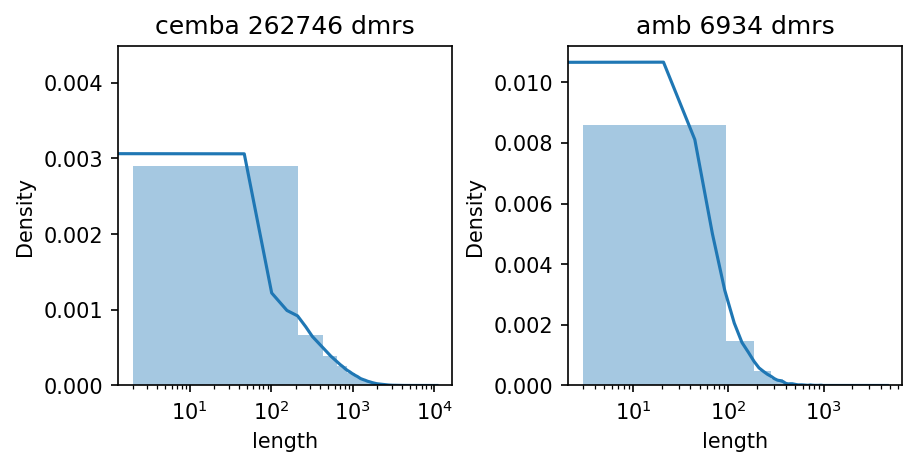

In [13]:
fig, axes = plt.subplots(figsize = (6,3), ncols = 2, dpi = 150, constrained_layout = True)

ax = axes[0]
sns.distplot(cemba_dmr['length'], ax = ax)
ax.set_title(f'cemba {cemba_dmr.shape[0]} dmrs')
ax.set_xscale('log')

ax = axes[1]
sns.distplot(admr['length'], ax = ax)
ax.set_title(f'amb {admr.shape[0]} dmrs')
ax.set_xscale('log')

In [14]:
subprocess.run(f"bedtools intersect -a {admr_path} -b {cemba_dmr_path} -wa -wb -f 0.2 > {ct}.overlap.bed", shell = True)

CompletedProcess(args='bedtools intersect -a /data/mC_FILTER_DMR_BED/L6bCT_ENT_Glut.Hypo-Hyper.aDMR.bed -b Cemba.HypoDMR.with-id/L6bCT_ENT_Glut.bed -wa -wb -f 0.2 > L6bCT_ENT_Glut.overlap.bed', returncode=0)

In [15]:
intersect_bed = pd.read_csv(f"{ct}.overlap.bed", sep = '\t', header = None)
print(f"{intersect_bed.shape[0]} admrs overlapped")

1884 admrs overlapped


## generate region bed

In [16]:
bulk_allc_paths = glob.glob(f"/data/female-amb/Celltype.Age.CGN-Merge/{ct}.*.CGN-Merge.allc.tsv.gz")
allc_df = pd.DataFrame(bulk_allc_paths)
allc_df['group'] = allc_df[0].apply(lambda x: pathlib.Path(x).name.split('.CGN-Merge')[0])
allc_df = allc_df[['group',0]]
allc_df.to_csv('bulk_allc_table.tsv', sep = '\t', header = None, index = None)

In [17]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
allc_table_path = 'bulk_allc_table.tsv'
cpu = 45
output_path = f"{ct}.AllDMR.mcds"

In [18]:
admr_path = f'/data/mC_FILTER_DMR_BED/{ct}.Hypo-Hyper.aDMR.bed'
cemba_dmr_path = f'Cemba.HypoDMR.with-id/{ct}.bed'
all_dmr_path = 'All.DMR.bed'

In [19]:
command = f"allcools generate-dataset  \
--allc_table {allc_table_path} \
--output_path {output_path} \
--chrom_size_path {chrom_size_path} \
--obs_dim sample \
--cpu {cpu} \
--chunk_size 1 \
--regions AllDMR {all_dmr_path} \
--quantifiers AllDMR count CGN,CHN \
"

In [21]:
subprocess.run(command, shell = True)

command	generate-dataset
allc_table	bulk_allc_table.tsv
output_path	L6bCT_ENT_Glut.AllDMR.mcds
chrom_size_path	/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes
obs_dim	sample
cpu	45
chunk_size	1
regions	[['AllDMR', 'All.DMR.bed']]
quantifiers	[['AllDMR', 'count', 'CGN,CHN']]
Executing generate-dataset...


[W::hts_idx_load3] The index file is older than the data file: /data/female-amb/Celltype.Age.CGN-Merge/L6bCT_ENT_Glut.9mo.CGN-Merge.allc.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /data/female-amb/Celltype.Age.CGN-Merge/L6bCT_ENT_Glut.18mo.CGN-Merge.allc.tsv.gz.tbi


Chunk 1 of AllDMR returned
Chunk 2 of AllDMR returned
Chunk 0 of AllDMR returned
generate-dataset finished.


CompletedProcess(args='allcools generate-dataset  --allc_table bulk_allc_table.tsv --output_path L6bCT_ENT_Glut.AllDMR.mcds --chrom_size_path /ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes --obs_dim sample --cpu 45 --chunk_size 1 --regions AllDMR All.DMR.bed --quantifiers AllDMR count CGN,CHN ', returncode=0)

In [25]:
# from ALLCools.mcds import MCDS
# mcds = MCDS.open(
#     output_path, 
#     obs_dim='cell', 
#     var_dim='aDMR', 
# )
# mcds.add_mc_frac(
# normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
#     clip_norm_value=10  # clip outlier values above 10 to 10
# )

In [24]:
#tmp= mcds.sel(mc_type = 'CGN', count_type = 'cov')

In [23]:
#tmp['aDMR_da_frac'].to_pandas().T

In [111]:
# command = f"allcools region \
# --allc_path {bulk_allc_paths[0]} \
# --output_prefix {amb_ct}.RegionDS/{group} \
# --chrom_size_path {chrom_size_path} \
# --region_bed_paths {admr_path} \
# --region_bed_names {amb_ct}-DMR \
# --cpu {cpu} \
# --mc_contexts CGN,CHN \
# "